# Figure S7F


# Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sympy import symbols, solve, simplify
import pandas as pd
import random 
import sympy as sp
plt.rcParams.update({'font.size': 20})

# Definitions

Function to plot together the exp data and the model predictions for the different cell types

In [2]:
def plot_celltypes(data_exp, data_model, col, axs, avg=True): 
    
    mean_data_exp = np.nanmean(data_exp)
    mean_data_model = np.nanmean(data_model)
    std_data_exp = np.nanstd(data_exp)
    std_data_model = np.nanstd(data_model)
    
    x = np.random.normal(1, 0.08, size=len(data_exp))
    axs.plot(x,data_exp,'.', color= col, alpha=0.3, markersize=10, zorder=1) 
     
    x = np.random.normal(2, 0.08, size=len(data_model))
    axs.plot(x,data_model,'.', color= col, alpha=0.3, markersize=10, zorder=1)
    
    if avg==True:
        x = 1 
        axs.errorbar(x,mean_data_exp ,std_data_exp, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)
   
        x = 2 
        axs.errorbar(x,mean_data_model ,std_data_model, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

Function to define the properties of the axis of a plot

In [3]:
def my_axsis(ax, xlim, ylim, xticks, title, xtickslabels, bold=True, scale='lin'):    
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_title(title)
    ax.set_xticklabels(xtickslabels)
    
    if bold==True:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.2)
            
    if scale=='log':
        ax.set_yscale('log', base=2)

# Model 

Definition of the parameters of the model

In [4]:
T, V1, V2, K1, K2, Kb = symbols('T V1 V2 K1 K2 Kb') 
Vs, Rb, Ks, Vrg, Qb, Krg = symbols('Vs Rb Ks Vrg Qb Krg')
R, F, Kd, Q, E, Ke = symbols('R F Kd Q E Ke')
S1, Qtot, S2, Rtot= symbols('S1 Qtot S2 Rtot')
Ap,kMM3,Er,KMM3,vMM4,KMM4 = symbols('Ap kMM3 Er KMM3 vMM4 KMM4')
I, kMM1, Er, KMM1, vMM2,KMM2 = symbols('I kMM1 Er KMM1 vMM2 KMM2')
vb, vo, Ap, Ka, Ki, I, k, O = symbols('vb vo Ap Ka Ki I k O')

The evolution equation for T 

In [5]:
# Evolution equation for T: 
expr = V1*(1-T)/(K1+(1-T))-V2*T/(K2+T)-Kb*T
expr_simplified= V1*(1-T)*(K2+T) -V2*T*(K1+(1-T))-Kb*T*(K1+(1-T))*(K2+T)
print('Evolution equation for T:')
print(expr)

# Substitute the expression for V1 and V2 in the evolution equation for T:  
expr_RQ= expr_simplified.subs([(V1, Vs*(R*F/(Kd+F))/(Ks+(R*F/(Kd+F)))),(V2, Vrg*(Q*E/(Ke+E))/(Krg+(Q*E/(Ke+E))))])

# Substitute the expressions for Q and R
expr_S1S2 = expr_RQ.subs([(R, Rtot*S1),(Q, Qtot*S2)])

# Expliciting the relation between S1 and S2 to obtain T(FGF, S1): 
expr_T = expr_S1S2.subs([(S2,-1.1265*S1 +0.9092)])

print('Evolution equation for T (all parameters explicited):')
print(expr_T)

# Solve the equation 
sol = solve(expr_T, T)[2]

Evolution equation for T:
-Kb*T - T*V2/(K2 + T) + V1*(1 - T)/(K1 - T + 1)
Evolution equation for T (all parameters explicited):
-E*Qtot*T*Vrg*(0.9092 - 1.1265*S1)*(K1 - T + 1)/((E + Ke)*(E*Qtot*(0.9092 - 1.1265*S1)/(E + Ke) + Krg)) + F*Rtot*S1*Vs*(1 - T)*(K2 + T)/((F + Kd)*(F*Rtot*S1/(F + Kd) + Ks)) - Kb*T*(K2 + T)*(K1 - T + 1)


Definition of the function ExprT that compute T as a function of all the parameters of the equation

In [6]:
def exprT(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5):
    sol_T = sol.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v)])
    sol_T = np.real(np.array(sol_T,complex))
    return sol_T

Definition of the function to compute Erk (as a function of T)

In [7]:
def Erk(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = [ Erk_max* T[i]**n/(T[i]**n +Kerk**n)+Erk_bas for i in range(len(T)) ]
    return Erk

def Erk_singlevalue(T,n, Kerk, Erk_max=1, Erk_bas=0): 
    Erk = Erk_max* T**n/(T**n +Kerk**n) + Erk_bas
    return Erk

Evolution equation for the activator Ap

In [8]:
expr_Ap = kMM3*Er*(1-Ap)/(KMM3+(1-Ap))-vMM4*Ap/(KMM4+Ap)
sol_Ap= solve(expr_Ap, Ap)[1] 

# Function to compute Ap as a function of the other parameters:  
def exprAp(kMM3_v=14,Er_v=0.5,KMM3_v=0.3,vMM4_v=1,KMM4_v=0.3):
    solAp= sol_Ap.subs([(kMM3,kMM3_v), (Er,Er_v), (KMM4,KMM4_v), (vMM4,vMM4_v), (KMM3,KMM3_v)]) 
    return solAp

Evolution equation for the inhibitor I

In [9]:
expr_I = -kMM1*Er*I/(KMM1+I)+vMM2*(1-I)/(KMM2+(1-I))
sol_I= solve(expr_I, I)[0] 

# Function to compute I as a function of the other parameters: 
def exprI(kMM1_v=14,Er_v=0.5,KMM1_v=0.3,vMM2_v=1,KMM2_v=0.3): 
    solI= sol_I.subs([(kMM1,kMM1_v), (Er,Er_v), (KMM1,KMM1_v), (vMM2,vMM2_v), (KMM2,KMM2_v)]) 
    return solI 

Compute Otx and define a function ExprOtx that compute Otx as a function of all the parameters of the equation

In [10]:
expr_Otx = vb+ vo*Ap**2/((Ka*(1+I/Ki))**2+Ap**2)-k*O
sol_Otx= solve(expr_Otx, O)[0]  

# Function to compute Otx as a function of the other parameters
def exprOtx(Ap_v, I_v, vb_v=0.001,vo_v=1,Ka_v=0.1,Ki_v=0.1,k_v=0.2, Omax=1, Obas=0): 
    solOtx= [sol_Otx.subs([(Ap, Ap_v[i]), (I, I_v[i]), (vb,vb_v), (vo,vo_v), (Ka,Ka_v), (Ki,Ki_v), (k,k_v)])*Omax +Obas for i in range(len(Ap_v))] 
    return solOtx

def exprOtx_singlevalue(Ap_v=0.5, I_v=0.5, vb_v=0.001,vo_v=1,Ka_v=0.1,Ki_v=0.1,k_v=0.2, Omax=1, Obas=0): 
    solOtx= sol_Otx.subs([(Ap, Ap_v), (I, I_v), (vb,vb_v), (vo,vo_v), (Ka,Ka_v), (Ki,Ki_v), (k,k_v)])*Omax +Obas 
    return solOtx

# Import the experimental data 

In [11]:
#read the excel file with the experimental data
data_S1 = pd.read_excel('/Users/rossanabettoni/Desktop/PhD/Article_PLOS/ExpData.xlsx', sheet_name='Cell surface contacts')
df_S1 = pd.DataFrame(data_S1)

data_Fig3A = pd.read_excel('/Users/rossanabettoni/Desktop/PhD/Article_PLOS/ExpData.xlsx', sheet_name='Fig 3A & S3A')
df_Fig3A = pd.DataFrame(data_Fig3A)

Experimental data figure 1C

In [12]:
# Reltive area of cell surface contact with FGF expressing cells (divided by cell type)
a65_RelContactArea_A = np.array(df_S1['a6.5 S1'].values.tolist())[0:25] 
a66_RelContactArea_A = np.array(df_S1['a6.6 S1'].values.tolist())[0:25] 
a67_RelContactArea_A = np.array(df_S1['a6.7 S1'].values.tolist())[0:25] 
a68_RelContactArea_A = np.array(df_S1['a6.8 S1'].values.tolist())[0:25] 

Experimental data figure 3A

In [13]:
# Levels of Otx expression (divided by cell type)
a65_Otx = np.array(df_Fig3A['a6.5'].values.tolist())
a66_Otx = np.array(df_Fig3A['a6.6'].values.tolist())
a67_Otx = np.array(df_Fig3A['a6.7'].values.tolist())
a68_Otx = np.array(df_Fig3A['a6.8'].values.tolist())

alldata_Otx = np.concatenate((a65_Otx,a66_Otx,a67_Otx,a68_Otx))

# Compute the mean of the experimental data 
a65_Otx_mean = np.nanmean(a65_Otx)
a66_Otx_mean = np.nanmean(a66_Otx)
a67_Otx_mean = np.nanmean(a67_Otx)
a68_Otx_mean = np.nanmean(a68_Otx)

# Compute the standard deviation
a65_Otx_std = np.nanstd(a65_Otx)
a66_Otx_std = np.nanstd(a66_Otx)
a67_Otx_std = np.nanstd(a67_Otx)
a68_Otx_std = np.nanstd(a68_Otx)

mean_Otx = [a65_Otx_mean, a66_Otx_mean, a67_Otx_mean, a68_Otx_mean]
std_Otx = [a65_Otx_std, a66_Otx_std, a67_Otx_std, a68_Otx_std]

# Results

## Figure S7F

Definition of the random parameters

In [14]:
def rand(x_st, perc=5, length=a65_RelContactArea_A): 
    x_rand = np.ones(len(length))
    x_min = x_st- x_st*perc/100
    x_max = x_st+ x_st*perc/100
    
    for i in range(len(length)): 
        x_rand[i] = np.round(random.uniform(x_min, x_max),4)
    
    return x_rand

In [15]:
p = 20

FGF_rand_a65 = rand(5, perc=p)
FGF_rand_a66 = rand(5, perc=p)
FGF_rand_a67 = rand(5, perc=p)
FGF_rand_a68 = rand(5, perc=p)

E_rand_a65 = rand(5, perc=p)
E_rand_a66 = rand(5, perc=p)
E_rand_a67 = rand(5, perc=p)
E_rand_a68 = rand(5, perc=p)

Rt_rand_a65 = rand(2000, perc=p)
Rt_rand_a66 = rand(2000, perc=p)
Rt_rand_a67 = rand(2000, perc=p)
Rt_rand_a68 = rand(2000, perc=p)

Qt_rand_a65 = rand(2000, perc=p)
Qt_rand_a66 = rand(2000, perc=p)
Qt_rand_a67 = rand(2000, perc=p)
Qt_rand_a68 = rand(2000, perc=p)

Kd_rand_a65 = rand(25, perc=p)
Kd_rand_a66 = rand(25, perc=p)
Kd_rand_a67 = rand(25, perc=p)
Kd_rand_a68 = rand(25, perc=p)

Ke_rand_a65 = rand(50, perc=p)
Ke_rand_a66 = rand(50, perc=p)
Ke_rand_a67 = rand(50, perc=p)
Ke_rand_a68 = rand(50, perc=p)

Kb_rand_a65 = rand(0.2, perc=p)
Kb_rand_a66 = rand(0.2, perc=p)
Kb_rand_a67 = rand(0.2, perc=p)
Kb_rand_a68 = rand(0.2, perc=p)

K1_rand_a65 = rand(0.5, perc=p)
K1_rand_a66 = rand(0.5, perc=p)
K1_rand_a67 = rand(0.5, perc=p)
K1_rand_a68 = rand(0.5, perc=p)

K2_rand_a65 = rand(0.2, perc=p)
K2_rand_a66 = rand(0.2, perc=p)
K2_rand_a67 = rand(0.2, perc=p)
K2_rand_a68 = rand(0.2, perc=p)

Krg_rand_a65 = rand(1200, perc=p)
Krg_rand_a66 = rand(1200, perc=p)
Krg_rand_a67 = rand(1200, perc=p)
Krg_rand_a68 = rand(1200, perc=p)

Ks_rand_a65 = rand(1200, perc=p)
Ks_rand_a66 = rand(1200, perc=p)
Ks_rand_a67 = rand(1200, perc=p)
Ks_rand_a68 = rand(1200, perc=p)

Vrg_rand_a65 = rand(0.4, perc=p)
Vrg_rand_a66 = rand(0.4, perc=p)
Vrg_rand_a67 = rand(0.4, perc=p)
Vrg_rand_a68 = rand(0.4, perc=p)

Vs_rand_a65 = rand(1, perc=p)
Vs_rand_a66 = rand(1, perc=p)
Vs_rand_a67 = rand(1, perc=p)
Vs_rand_a68 = rand(1, perc=p)

### Parameters linked to the FGF pathway randomly choosen

Compute Erk activity 

In [16]:
T_pred_a65 = [exprT(S1_v= a65_RelContactArea_A[i], F_v=FGF_rand_a65[i], Kd_v=Kd_rand_a65[i],Ks_v=Ks_rand_a65[i], Rtot_v=Rt_rand_a65[i],Vs_v=Vs_rand_a65[i],K1_v =K1_rand_a65[i]) for i in range(len(a65_RelContactArea_A))]
T_pred_a66 = [exprT(S1_v= a66_RelContactArea_A[i], F_v=FGF_rand_a66[i], Kd_v=Kd_rand_a66[i],Ks_v=Ks_rand_a66[i], Rtot_v=Rt_rand_a66[i],Vs_v=Vs_rand_a65[i],K1_v =K1_rand_a66[i]) for i in range(len(a66_RelContactArea_A))]
T_pred_a67 = [exprT(S1_v= a67_RelContactArea_A[i], F_v=FGF_rand_a67[i], Kd_v=Kd_rand_a67[i],Ks_v=Ks_rand_a67[i], Rtot_v=Rt_rand_a67[i],Vs_v=Vs_rand_a65[i],K1_v =K1_rand_a67[i]) for i in range(len(a67_RelContactArea_A))]
T_pred_a68 = [exprT(S1_v= a68_RelContactArea_A[i], F_v=FGF_rand_a68[i], Kd_v=Kd_rand_a68[i],Ks_v=Ks_rand_a68[i], Rtot_v=Rt_rand_a68[i],Vs_v=Vs_rand_a65[i],K1_v =K1_rand_a68[i]) for i in range(len(a68_RelContactArea_A))]

Erk_pred_a65_a = Erk(T_pred_a65)
Erk_pred_a66_a = Erk(T_pred_a66)
Erk_pred_a67_a = Erk(T_pred_a67)
Erk_pred_a68_a = Erk(T_pred_a68)

# Compute the mean Erk value for each cell type (with our model)
mean_a65_Erk_model_a= np.mean(Erk_pred_a65_a) 
mean_a66_Erk_model_a= np.mean(Erk_pred_a66_a)
mean_a67_Erk_model_a= np.mean(Erk_pred_a67_a)
mean_a68_Erk_model_a= np.mean(Erk_pred_a68_a)
Erk_mean_a = [mean_a65_Erk_model_a, mean_a66_Erk_model_a, mean_a67_Erk_model_a, mean_a68_Erk_model_a]

# Compute the std
sdev_a65_Erk_model_a = np.std(Erk_pred_a65_a)
sdev_a66_Erk_model_a = np.std(Erk_pred_a66_a)
sdev_a67_Erk_model_a = np.std(Erk_pred_a67_a)
sdev_a68_Erk_model_a = np.std(Erk_pred_a68_a)
sdev_a = [sdev_a65_Erk_model_a, sdev_a66_Erk_model_a, sdev_a67_Erk_model_a, sdev_a68_Erk_model_a]

Compute Otx expression

In [17]:
# Compute Ap
Ap_pred_65 = [exprAp(Er_v=Erk_pred_a65_a[i]) for i in range(len(Erk_pred_a65_a))]
Ap_pred_66 = [exprAp(Er_v=Erk_pred_a66_a[i]) for i in range(len(Erk_pred_a66_a))]
Ap_pred_67 = [exprAp(Er_v=Erk_pred_a67_a[i]) for i in range(len(Erk_pred_a67_a))]
Ap_pred_68 = [exprAp(Er_v=Erk_pred_a68_a[i]) for i in range(len(Erk_pred_a68_a))]

# Compute I 
I_pred_65 = [exprI(Er_v=Erk_pred_a65_a[i]) for i in range(len(Erk_pred_a65_a))]
I_pred_66 = [exprI(Er_v=Erk_pred_a66_a[i]) for i in range(len(Erk_pred_a66_a))]
I_pred_67 = [exprI(Er_v=Erk_pred_a67_a[i]) for i in range(len(Erk_pred_a67_a))]
I_pred_68 = [exprI(Er_v=Erk_pred_a68_a[i]) for i in range(len(Erk_pred_a68_a))]

# Compute Otx expression 
Otx_pred_65_e = np.array(exprOtx(Ap_v=Ap_pred_65,I_v=I_pred_65)).astype(float)
Otx_pred_66_e = np.array(exprOtx(Ap_v=Ap_pred_66,I_v=I_pred_66)).astype(float)
Otx_pred_67_e = np.array(exprOtx(Ap_v=Ap_pred_67,I_v=I_pred_67)).astype(float)
Otx_pred_68_e = np.array(exprOtx(Ap_v=Ap_pred_68,I_v=I_pred_68)).astype(float)

# Compute the mean Otx value for each cell type (with our model)
mean_a65_Otx_model_e= np.mean(Otx_pred_65_e) 
mean_a66_Otx_model_e= np.mean(Otx_pred_66_e)
mean_a67_Otx_model_e= np.mean(Otx_pred_67_e)
mean_a68_Otx_model_e= np.mean(Otx_pred_68_e)
Otx_mean_e = [mean_a65_Otx_model_e, mean_a66_Otx_model_e, mean_a67_Otx_model_e, mean_a68_Otx_model_e]

# Compute the std
sdev_a65_Otx_model_e= np.std(Otx_pred_65_e) 
sdev_a66_Otx_model_e= np.std(Otx_pred_66_e)
sdev_a67_Otx_model_e= np.std(Otx_pred_67_e)
sdev_a68_Otx_model_e= np.std(Otx_pred_68_e)
Otx_sdev_e = [sdev_a65_Otx_model_e, sdev_a66_Otx_model_e, sdev_a67_Otx_model_e, sdev_a68_Otx_model_e]

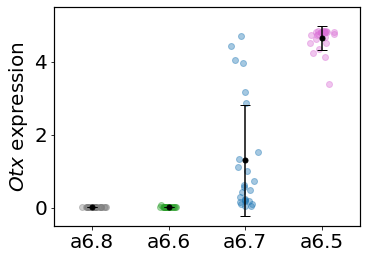

In [18]:
plt.figure(figsize=(5.5,4))

x = np.random.normal(1, 0.08, size=len(Otx_pred_68_e)) #'.', color='grey', alpha=0.3,markersize=10
plt.plot(x,Otx_pred_68_e,'.', color='grey', alpha=0.4,markersize=12, zorder=1)
    
x = np.random.normal(2, 0.08, size=len(Otx_pred_66_e))
plt.plot(x,Otx_pred_66_e,'.', color='tab:green', alpha=0.4,markersize=12, zorder=1)
    
x = np.random.normal(3, 0.08, size=len(Otx_pred_67_e))
plt.plot(x,Otx_pred_67_e,'.', color='tab:blue', alpha=0.4,markersize=12, zorder=1)

x = np.random.normal(4, 0.08, size=len(Otx_pred_65_e))
plt.plot(x,Otx_pred_65_e,'.', color='orchid', alpha=0.4,markersize=12, zorder=1)

x = [4, 2, 3, 1]
plt.errorbar(x, Otx_mean_e, Otx_sdev_e, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

ax=plt.gca()
#plt.yticks([2**6,2**7,2**8,2**9,2**10],['64', '128', '256', '512', '1024'])
my_axsis(ax, xlim=[0.5,4.5], ylim=[-0.5, 5.5], xticks=[1,2,3,4], title='', xtickslabels=['a6.8', 'a6.6', 'a6.7','a6.5'], bold=True)

plt.ylabel('$Otx$ expression')
plt.tight_layout()
plt.show()

### Parameters linked to the ephrin pathway randomly choosen

Compute Erk activity 

In [19]:
T_pred_a65 = [exprT(S1_v= a65_RelContactArea_A[i], E_v=E_rand_a65[i], Ke_v=Ke_rand_a65[i],Krg_v=Krg_rand_a65[i], Qtot_v=Qt_rand_a65[i],Vrg_v=Vrg_rand_a65[i],K2_v =K2_rand_a65[i]) for i in range(len(a65_RelContactArea_A))]
T_pred_a66 = [exprT(S1_v= a66_RelContactArea_A[i], E_v=E_rand_a66[i], Ke_v=Ke_rand_a66[i],Krg_v=Krg_rand_a66[i], Qtot_v=Qt_rand_a66[i],Vrg_v=Vrg_rand_a65[i],K2_v =K2_rand_a66[i]) for i in range(len(a66_RelContactArea_A))]
T_pred_a67 = [exprT(S1_v= a67_RelContactArea_A[i], E_v=E_rand_a67[i], Ke_v=Ke_rand_a67[i],Krg_v=Krg_rand_a67[i], Qtot_v=Qt_rand_a67[i],Vrg_v=Vrg_rand_a65[i],K2_v =K2_rand_a67[i]) for i in range(len(a67_RelContactArea_A))]
T_pred_a68 = [exprT(S1_v= a68_RelContactArea_A[i], E_v=E_rand_a68[i], Ke_v=Ke_rand_a68[i],Krg_v=Krg_rand_a68[i], Qtot_v=Qt_rand_a68[i],Vrg_v=Vrg_rand_a65[i],K2_v =K2_rand_a68[i]) for i in range(len(a68_RelContactArea_A))]

Erk_pred_a65_a = Erk(T_pred_a65)
Erk_pred_a66_a = Erk(T_pred_a66)
Erk_pred_a67_a = Erk(T_pred_a67)
Erk_pred_a68_a = Erk(T_pred_a68)

# Compute the mean Erk value for each cell type (with our model)
mean_a65_Erk_model_a= np.mean(Erk_pred_a65_a) 
mean_a66_Erk_model_a= np.mean(Erk_pred_a66_a)
mean_a67_Erk_model_a= np.mean(Erk_pred_a67_a)
mean_a68_Erk_model_a= np.mean(Erk_pred_a68_a)
Erk_mean_a = [mean_a65_Erk_model_a, mean_a66_Erk_model_a, mean_a67_Erk_model_a, mean_a68_Erk_model_a]

# Compute the std
sdev_a65_Erk_model_a = np.std(Erk_pred_a65_a)
sdev_a66_Erk_model_a = np.std(Erk_pred_a66_a)
sdev_a67_Erk_model_a = np.std(Erk_pred_a67_a)
sdev_a68_Erk_model_a = np.std(Erk_pred_a68_a)
sdev_a = [sdev_a65_Erk_model_a, sdev_a66_Erk_model_a, sdev_a67_Erk_model_a, sdev_a68_Erk_model_a]

Compute Otx expression

In [20]:
# Compute Ap
Ap_pred_65 = [exprAp(Er_v=Erk_pred_a65_a[i]) for i in range(len(Erk_pred_a65_a))]
Ap_pred_66 = [exprAp(Er_v=Erk_pred_a66_a[i]) for i in range(len(Erk_pred_a66_a))]
Ap_pred_67 = [exprAp(Er_v=Erk_pred_a67_a[i]) for i in range(len(Erk_pred_a67_a))]
Ap_pred_68 = [exprAp(Er_v=Erk_pred_a68_a[i]) for i in range(len(Erk_pred_a68_a))]

# Compute I 
I_pred_65 = [exprI(Er_v=Erk_pred_a65_a[i]) for i in range(len(Erk_pred_a65_a))]
I_pred_66 = [exprI(Er_v=Erk_pred_a66_a[i]) for i in range(len(Erk_pred_a66_a))]
I_pred_67 = [exprI(Er_v=Erk_pred_a67_a[i]) for i in range(len(Erk_pred_a67_a))]
I_pred_68 = [exprI(Er_v=Erk_pred_a68_a[i]) for i in range(len(Erk_pred_a68_a))]

# Compute Otx expression 
Otx_pred_65_e = np.array(exprOtx(Ap_v=Ap_pred_65,I_v=I_pred_65)).astype(float)
Otx_pred_66_e = np.array(exprOtx(Ap_v=Ap_pred_66,I_v=I_pred_66)).astype(float)
Otx_pred_67_e = np.array(exprOtx(Ap_v=Ap_pred_67,I_v=I_pred_67)).astype(float)
Otx_pred_68_e = np.array(exprOtx(Ap_v=Ap_pred_68,I_v=I_pred_68)).astype(float)

# Compute the mean Otx value for each cell type (with our model)
mean_a65_Otx_model_e= np.mean(Otx_pred_65_e) 
mean_a66_Otx_model_e= np.mean(Otx_pred_66_e)
mean_a67_Otx_model_e= np.mean(Otx_pred_67_e)
mean_a68_Otx_model_e= np.mean(Otx_pred_68_e)
Otx_mean_e = [mean_a65_Otx_model_e, mean_a66_Otx_model_e, mean_a67_Otx_model_e, mean_a68_Otx_model_e]

# Compute the std
sdev_a65_Otx_model_e= np.std(Otx_pred_65_e) 
sdev_a66_Otx_model_e= np.std(Otx_pred_66_e)
sdev_a67_Otx_model_e= np.std(Otx_pred_67_e)
sdev_a68_Otx_model_e= np.std(Otx_pred_68_e)
Otx_sdev_e = [sdev_a65_Otx_model_e, sdev_a66_Otx_model_e, sdev_a67_Otx_model_e, sdev_a68_Otx_model_e]



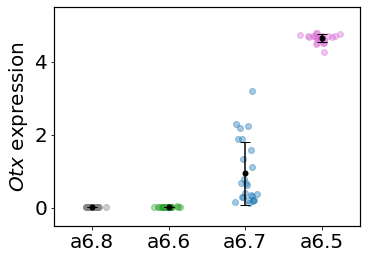

In [21]:
plt.figure(figsize=(5.5,4))

x = np.random.normal(1, 0.08, size=len(Otx_pred_68_e)) #'.', color='grey', alpha=0.3,markersize=10
plt.plot(x,Otx_pred_68_e,'.', color='grey', alpha=0.4,markersize=12, zorder=1)
    
x = np.random.normal(2, 0.08, size=len(Otx_pred_66_e))
plt.plot(x,Otx_pred_66_e,'.', color='tab:green', alpha=0.4,markersize=12, zorder=1)
    
x = np.random.normal(3, 0.08, size=len(Otx_pred_67_e))
plt.plot(x,Otx_pred_67_e,'.', color='tab:blue', alpha=0.4,markersize=12, zorder=1)

x = np.random.normal(4, 0.08, size=len(Otx_pred_65_e))
plt.plot(x,Otx_pred_65_e,'.', color='orchid', alpha=0.4,markersize=12, zorder=1)

x = [4, 2, 3, 1]
plt.errorbar(x, Otx_mean_e, Otx_sdev_e, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

ax=plt.gca()
#plt.yticks([2**6,2**7,2**8,2**9,2**10],['64', '128', '256', '512', '1024'])
my_axsis(ax, xlim=[0.5,4.5], ylim=[-0.5, 5.5], xticks=[1,2,3,4], title='', xtickslabels=['a6.8', 'a6.6', 'a6.7','a6.5'], bold=True)

plt.ylabel('$Otx$ expression')
plt.tight_layout()
plt.show()

### All parameters

In [22]:
Kerk_rand_a65 = rand(0.5, perc=p)
Kerk_rand_a66 = rand(0.5, perc=p)
Kerk_rand_a67 = rand(0.5, perc=p)
Kerk_rand_a68 = rand(0.5, perc=p)

KMM3_rand_a65 = rand(0.05, perc=p)
KMM3_rand_a66 = rand(0.05, perc=p)
KMM3_rand_a67 = rand(0.05, perc=p)
KMM3_rand_a68 = rand(0.05, perc=p)

KMM4_rand_a65 = rand(0.05, perc=p)
KMM4_rand_a66 = rand(0.05, perc=p)
KMM4_rand_a67 = rand(0.05, perc=p)
KMM4_rand_a68 = rand(0.05, perc=p)

KMM1_rand_a65 = rand(0.05, perc=p)
KMM1_rand_a66 = rand(0.05, perc=p)
KMM1_rand_a67 = rand(0.05, perc=p)
KMM1_rand_a68 = rand(0.05, perc=p)

KMM2_rand_a65 = rand(0.05, perc=p)
KMM2_rand_a66 = rand(0.05, perc=p)
KMM2_rand_a67 = rand(0.05, perc=p)
KMM2_rand_a68 = rand(0.05, perc=p)

kMM3_rand_a65 = rand(12, perc=p)
kMM3_rand_a66 = rand(12, perc=p)
kMM3_rand_a67 = rand(12, perc=p)
kMM3_rand_a68 = rand(12, perc=p)

kMM1_rand_a65 = rand(12, perc=p)
kMM1_rand_a66 = rand(12, perc=p)
kMM1_rand_a67 = rand(12, perc=p)
kMM1_rand_a68 = rand(12, perc=p)

vMM4_rand_a65 = rand(1, perc=p)
vMM4_rand_a66 = rand(1, perc=p)
vMM4_rand_a67 = rand(1, perc=p)
vMM4_rand_a68 = rand(1, perc=p)

vMM2_rand_a65 = rand(1, perc=p)
vMM2_rand_a66 = rand(1, perc=p)
vMM2_rand_a67 = rand(1, perc=p)
vMM2_rand_a68 = rand(1, perc=p)

k_rand_a65 = rand(0.2, perc=p)
k_rand_a66 = rand(0.2, perc=p)
k_rand_a67 = rand(0.2, perc=p)
k_rand_a68 = rand(0.2, perc=p)

Ki_rand_a65 = rand(0.1, perc=p)
Ki_rand_a66 = rand(0.1, perc=p)
Ki_rand_a67 = rand(0.1, perc=p)
Ki_rand_a68 = rand(0.1, perc=p)

Ka_rand_a65 = rand(0.1, perc=p)
Ka_rand_a66 = rand(0.1, perc=p)
Ka_rand_a67 = rand(0.1, perc=p)
Ka_rand_a68 = rand(0.1, perc=p)

vo_rand_a65 = rand(1, perc=p)
vo_rand_a66 = rand(1, perc=p)
vo_rand_a67 = rand(1, perc=p)
vo_rand_a68 = rand(1, perc=p)

vb_rand_a65 = rand(0.001, perc=p)
vb_rand_a66 = rand(0.001, perc=p)
vb_rand_a67 = rand(0.001, perc=p)
vb_rand_a68 = rand(0.001, perc=p)

Compute Erk activity 

In [23]:
Erk_max= 1    
Erk_bas = 0 
n_erk =2

T_pred_a65 = [exprT(S1_v= a65_RelContactArea_A[i],Vs_v=Vs_rand_a65[i], Vrg_v=Vrg_rand_a65[i], K1_v=K1_rand_a65[i],K2_v=K2_rand_a65[i],Ks_v=Ks_rand_a65[i], Krg_v=Krg_rand_a65[i], F_v=FGF_rand_a65[i],E_v=E_rand_a65[i],Kd_v=Kd_rand_a65[i],Ke_v=Ke_rand_a65[i],Kb_v=Kb_rand_a65[i], Rtot_v=Rt_rand_a65[i],Qtot_v=Qt_rand_a65[i]) for i in range(len(a65_RelContactArea_A))]
T_pred_a66 = [exprT(S1_v= a66_RelContactArea_A[i],Vs_v=Vs_rand_a66[i], Vrg_v=Vrg_rand_a66[i], K1_v=K1_rand_a66[i],K2_v=K2_rand_a66[i],Ks_v=Ks_rand_a66[i], Krg_v=Krg_rand_a66[i], F_v=FGF_rand_a66[i],E_v=E_rand_a66[i],Kd_v=Kd_rand_a66[i],Ke_v=Ke_rand_a66[i],Kb_v=Kb_rand_a66[i], Rtot_v=Rt_rand_a66[i],Qtot_v=Qt_rand_a66[i]) for i in range(len(a66_RelContactArea_A))]
T_pred_a67 = [exprT(S1_v= a67_RelContactArea_A[i],Vs_v=Vs_rand_a67[i], Vrg_v=Vrg_rand_a67[i], K1_v=K1_rand_a67[i],K2_v=K2_rand_a67[i],Ks_v=Ks_rand_a67[i], Krg_v=Krg_rand_a67[i], F_v=FGF_rand_a67[i],E_v=E_rand_a67[i],Kd_v=Kd_rand_a67[i],Ke_v=Ke_rand_a67[i],Kb_v=Kb_rand_a67[i], Rtot_v=Rt_rand_a67[i],Qtot_v=Qt_rand_a67[i]) for i in range(len(a67_RelContactArea_A))]
T_pred_a68 = [exprT(S1_v= a68_RelContactArea_A[i],Vs_v=Vs_rand_a68[i], Vrg_v=Vrg_rand_a68[i], K1_v=K1_rand_a68[i],K2_v=K2_rand_a68[i],Ks_v=Ks_rand_a68[i], Krg_v=Krg_rand_a68[i], F_v=FGF_rand_a68[i],E_v=E_rand_a68[i],Kd_v=Kd_rand_a68[i],Ke_v=Ke_rand_a68[i],Kb_v=Kb_rand_a68[i], Rtot_v=Rt_rand_a68[i],Qtot_v=Qt_rand_a68[i]) for i in range(len(a68_RelContactArea_A))]
Erk_pred_a65_a = [Erk_singlevalue(T_pred_a65[i], n_erk, Kerk_rand_a65[i], Erk_max, Erk_bas) for i in range(len(a65_RelContactArea_A))]
Erk_pred_a66_a = [Erk_singlevalue(T_pred_a66[i], n_erk, Kerk_rand_a66[i], Erk_max, Erk_bas) for i in range(len(a66_RelContactArea_A))]
Erk_pred_a67_a = [Erk_singlevalue(T_pred_a67[i], n_erk, Kerk_rand_a67[i], Erk_max, Erk_bas) for i in range(len(a67_RelContactArea_A))]
Erk_pred_a68_a = [Erk_singlevalue(T_pred_a68[i], n_erk, Kerk_rand_a68[i], Erk_max, Erk_bas) for i in range(len(a68_RelContactArea_A))]

# Compute the mean Erk value for each cell type (with our model)
mean_a65_Erk_model_a= np.mean(Erk_pred_a65_a) 
mean_a66_Erk_model_a= np.mean(Erk_pred_a66_a)
mean_a67_Erk_model_a= np.mean(Erk_pred_a67_a)
mean_a68_Erk_model_a= np.mean(Erk_pred_a68_a)
Erk_mean_a = [mean_a65_Erk_model_a, mean_a66_Erk_model_a, mean_a67_Erk_model_a, mean_a68_Erk_model_a]

# Compute the std
sdev_a65_Erk_model_a = np.std(Erk_pred_a65_a)
sdev_a66_Erk_model_a = np.std(Erk_pred_a66_a)
sdev_a67_Erk_model_a = np.std(Erk_pred_a67_a)
sdev_a68_Erk_model_a = np.std(Erk_pred_a68_a)
sdev_a = [sdev_a65_Erk_model_a, sdev_a66_Erk_model_a, sdev_a67_Erk_model_a, sdev_a68_Erk_model_a]

Compute Otx expression

In [24]:
Omax_value =1 
Obas_value =0

Ap_pred_a65 = [exprAp(Er_v=Erk_pred_a65_a[i], KMM3_v=KMM3_rand_a65[i], KMM4_v=KMM4_rand_a65[i], kMM3_v= kMM3_rand_a65[i], vMM4_v=vMM4_rand_a65[i]) for i in range(len(Erk_pred_a65_a))]
Ap_pred_a66 = [exprAp(Er_v=Erk_pred_a66_a[i], KMM3_v=KMM3_rand_a66[i], KMM4_v=KMM4_rand_a66[i], kMM3_v= kMM3_rand_a66[i], vMM4_v=vMM4_rand_a66[i]) for i in range(len(Erk_pred_a66_a))]
Ap_pred_a67 = [exprAp(Er_v=Erk_pred_a67_a[i], KMM3_v=KMM3_rand_a67[i], KMM4_v=KMM4_rand_a67[i], kMM3_v= kMM3_rand_a67[i], vMM4_v=vMM4_rand_a67[i]) for i in range(len(Erk_pred_a67_a))]
Ap_pred_a68 = [exprAp(Er_v=Erk_pred_a68_a[i], KMM3_v=KMM3_rand_a68[i], KMM4_v=KMM4_rand_a68[i], kMM3_v= kMM3_rand_a68[i], vMM4_v=vMM4_rand_a68[i]) for i in range(len(Erk_pred_a68_a))]

I_pred_a65 = [exprI(Er_v=Erk_pred_a65_a[i], KMM1_v=KMM1_rand_a65[i], KMM2_v=KMM2_rand_a65[i], kMM1_v= kMM1_rand_a65[i], vMM2_v=vMM2_rand_a65[i]) for i in range(len(Erk_pred_a65_a))]
I_pred_a66 = [exprI(Er_v=Erk_pred_a66_a[i], KMM1_v=KMM1_rand_a66[i], KMM2_v=KMM2_rand_a66[i], kMM1_v= kMM1_rand_a66[i], vMM2_v=vMM2_rand_a66[i]) for i in range(len(Erk_pred_a66_a))]
I_pred_a67 = [exprI(Er_v=Erk_pred_a67_a[i], KMM1_v=KMM1_rand_a67[i], KMM2_v=KMM2_rand_a67[i], kMM1_v= kMM1_rand_a67[i], vMM2_v=vMM2_rand_a67[i]) for i in range(len(Erk_pred_a67_a))]
I_pred_a68 = [exprI(Er_v=Erk_pred_a68_a[i], KMM1_v=KMM1_rand_a68[i], KMM2_v=KMM2_rand_a68[i], kMM1_v= kMM1_rand_a68[i], vMM2_v=vMM2_rand_a68[i]) for i in range(len(Erk_pred_a68_a))]

# Compute Otx expression

Otx_pred_a65_e = np.array([exprOtx_singlevalue(Ap_v=Ap_pred_a65[i],I_v=I_pred_a65[i], Omax = Omax_value, Obas = Obas_value, k_v=k_rand_a65[i], Ka_v=Ka_rand_a65[i], vb_v=vb_rand_a65[i], vo_v=vo_rand_a65[i]) for i in range(len(Ap_pred_a65))])
Otx_pred_a66_e = np.array([exprOtx_singlevalue(Ap_v=Ap_pred_a66[i],I_v=I_pred_a66[i], Omax = Omax_value, Obas = Obas_value, k_v=k_rand_a66[i], Ka_v=Ka_rand_a66[i], vb_v=vb_rand_a66[i], vo_v=vo_rand_a66[i]) for i in range(len(Ap_pred_a66))])
Otx_pred_a67_e = np.array([exprOtx_singlevalue(Ap_v=Ap_pred_a67[i],I_v=I_pred_a67[i], Omax = Omax_value, Obas = Obas_value, k_v=k_rand_a67[i], Ka_v=Ka_rand_a67[i], vb_v=vb_rand_a67[i], vo_v=vo_rand_a67[i]) for i in range(len(Ap_pred_a67))])
Otx_pred_a68_e = np.array([exprOtx_singlevalue(Ap_v=Ap_pred_a68[i],I_v=I_pred_a68[i], Omax = Omax_value, Obas = Obas_value, k_v=k_rand_a68[i], Ka_v=Ka_rand_a68[i], vb_v=vb_rand_a68[i], vo_v=vo_rand_a68[i]) for i in range(len(Ap_pred_a68))])

Otx_pred_a65_e = Otx_pred_a65_e.astype(float)
Otx_pred_a66_e = Otx_pred_a66_e.astype(float)
Otx_pred_a67_e = Otx_pred_a67_e.astype(float)
Otx_pred_a68_e = Otx_pred_a68_e.astype(float)

# Compute mean
a65_Otx_mean_pred_e = np.mean(Otx_pred_a65_e)
a66_Otx_mean_pred_e = np.mean(Otx_pred_a66_e)
a67_Otx_mean_pred_e = np.mean(Otx_pred_a67_e)
a68_Otx_mean_pred_e = np.mean(Otx_pred_a68_e)

# Compute std
a65_Otx_std_pred_e = np.std(Otx_pred_a65_e)
a66_Otx_std_pred_e = np.std(Otx_pred_a66_e)
a67_Otx_std_pred_e = np.std(Otx_pred_a67_e)
a68_Otx_std_pred_e = np.std(Otx_pred_a68_e)

mean_Otx_pred_e = [a65_Otx_mean_pred_e, a66_Otx_mean_pred_e, a67_Otx_mean_pred_e, a68_Otx_mean_pred_e]
std_Otx_pred_e = [a65_Otx_std_pred_e, a66_Otx_std_pred_e, a67_Otx_std_pred_e, a68_Otx_std_pred_e]


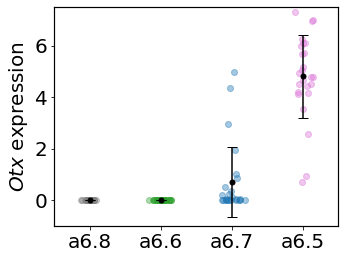

In [25]:
plt.figure(figsize=(5.2,4))

x = np.random.normal(1, 0.08, size=len(Otx_pred_a68_e)) #'.', color='grey', alpha=0.3,markersize=10
plt.plot(x,Otx_pred_a68_e,'.', color='grey', alpha=0.4,markersize=12, zorder=1)
    
x = np.random.normal(2, 0.08, size=len(Otx_pred_a66_e))
plt.plot(x,Otx_pred_a66_e,'.', color='tab:green', alpha=0.4,markersize=12, zorder=1)
    
x = np.random.normal(3, 0.08, size=len(Otx_pred_a67_e))
plt.plot(x,Otx_pred_a67_e,'.', color='tab:blue', alpha=0.4,markersize=12, zorder=1)

x = np.random.normal(4, 0.08, size=len(Otx_pred_a65_e))
plt.plot(x,Otx_pred_a65_e,'.', color='orchid', alpha=0.4,markersize=12, zorder=1)

x = [4, 2, 3, 1]
plt.errorbar(x, mean_Otx_pred_e, std_Otx_pred_e, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

ax=plt.gca()
#plt.yticks([2**6,2**7,2**8,2**9,2**10],['64', '128', '256', '512', '1024'])
my_axsis(ax, xlim=[0.5,4.5], ylim=[-1, 7.5], xticks=[1,2,3,4], title='', xtickslabels=['a6.8', 'a6.6', 'a6.7','a6.5'], bold=True)

plt.ylabel('$Otx$ expression')
plt.tight_layout()
plt.show()